In [10]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
from scipy.fftpack import fft, ifft
from scipy import signal

import general
import eegFilter

filename = "180903-1-5.mat"
datadir = "../../Data/Chen Zhou/EEG/Compact"
resultdir = "../../Result/"
data = loadmat(os.path.join(datadir, filename))
channels = data["channels"]
markers = data["markers"][0,:]
times = data["times"][0,:]

In [11]:
chidx = 51
cue_onset = markers['grating'][0][0,:]

fs = 2000
roi = (-2,5)
ch_raw = channels[chidx,:]
ch_split = general.split_datawithmarker(ch_raw, cue_onset, roi, fs)

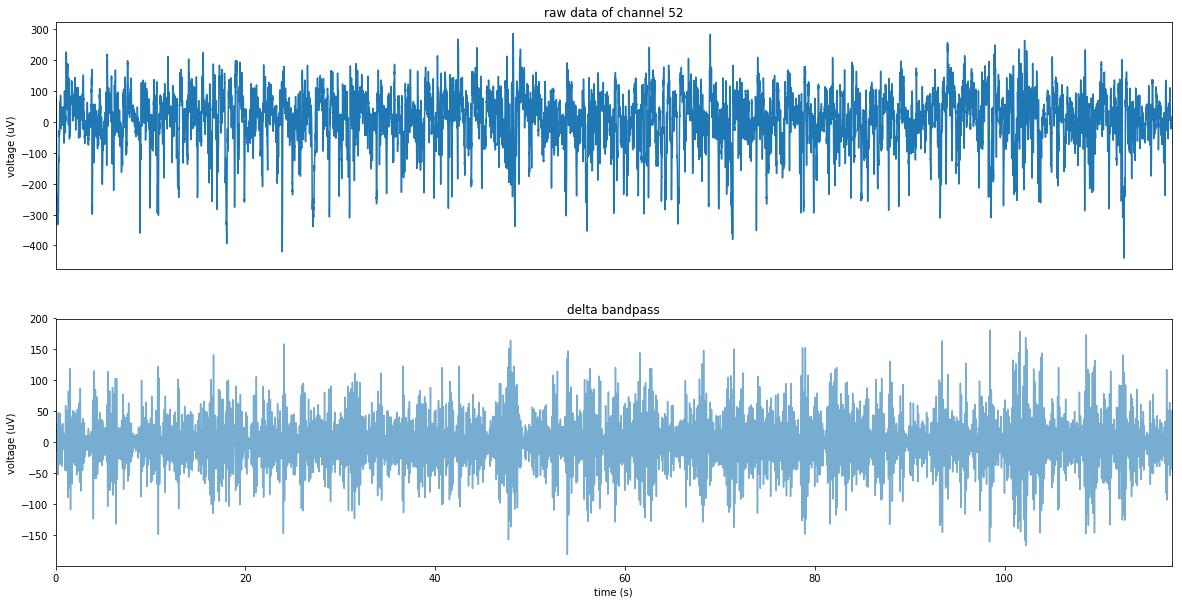

In [18]:
targetband = "delta"
lowcut, highcut = eegFilter.getbandrange(targetband)

# #####
# # The Nyquist rate of the signal.
# nyq_rate = fs / 2.0

# # The desired width of the transition from pass to stop,
# # relative to the Nyquist rate.  We'll design the filter
# # with a 5 Hz transition width.
# width = lowcut/nyq_rate

# # The desired attenuation in the stop band, in dB.
# ripple_db = 60.0

# # Compute the order and Kaiser parameter for the FIR filter.
# N, beta = signal.kaiserord(ripple_db, width)

# # The cutoff frequency of the filter.
# cutoff_hz = highcut

# # Use firwin with a Kaiser window to create a lowpass FIR filter.
# taps = signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# # Use lfilter to filter x with the FIR filter.
# ch_raw_bp = signal.filtfilt(taps, 1.0, ch_raw)

#####

a, b = signal.iirfilter(4, [lowcut/fs*2*np.pi, highcut/fs*2*np.pi], btype='band', ftype='butter')


zi = signal.lfilter_zi(a,b)
ch_raw_bp, _ = signal.lfilter(a,b,ch_raw, zi=zi*ch_raw[0])
# ch_raw_bp, _ = signal.lfilter(b,a,ch_raw_bp, zi=zi*ch_raw_bp[0])
# ch_raw_bp = signal.filtfilt(a, b, ch_raw)

# ch_raw_bp_mu = np.mean(ch_raw_bp)
# ch_raw_bp_sig = np.std(ch_raw_bp)

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.plot(times, ch_raw)
plt.xlim([times[0], times[-1]])
plt.xticks([])
plt.title("raw data of channel %d"%(chidx+1))
plt.ylabel("voltage (uV)")
# plt.xlabel("time (s)")

plt.subplot(2,1,2)
plt.plot(times, ch_raw_bp, alpha=0.6)
# plt.hlines(ch_raw_bp_mu, times[0], times[-1], linestyle='--', linewidth=1)
# plt.hlines(ch_raw_bp_mu+ch_raw_bp_sig*2, times[0], times[-1], 'r',linestyle='--', linewidth=1)
# plt.vlines(cue_onset, np.min(ch_raw_bp), np.max(ch_raw_bp), linewidth=1)

plt.xlim([times[0], times[-1]])
# plt.xlim([1,8])
plt.title("%s bandpass"%targetband)
plt.ylabel("voltage (uV)")
plt.xlabel("time (s)")

plt.show()

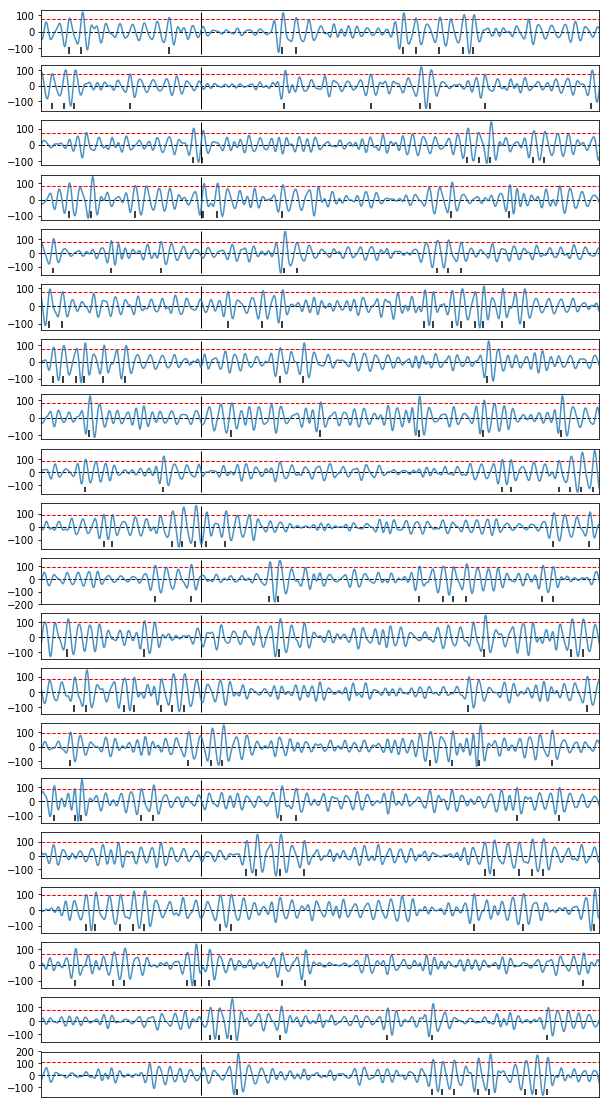

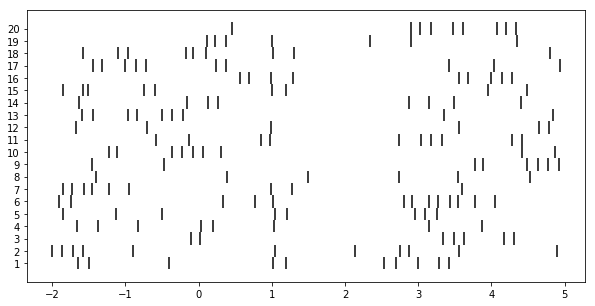

In [19]:
ch_raw_bp_split = general.split_datawithmarker(ch_raw_bp, cue_onset, roi, fs)
trialtotal = np.size(cue_onset)
tspec = np.linspace(-2,5,7*fs)
nthresh = 2

spiketrain = []

plt.figure(figsize=(10,1*trialtotal))

for trialN in range(trialtotal):
    ch_bp = ch_raw_bp_split[trialN,:]

    ch_bp_mu = np.mean(ch_bp)
    ch_bp_sig = np.std(ch_bp)

    spike = general.group_consecutive(np.where(ch_bp > ch_bp_mu+ch_bp_sig*nthresh)[0])
    spike = [item[0] for item in spike if len(item)>0]
    spiketrain.append(spike)
    
    plt.subplot(trialtotal, 1, trialN+1)

    plt.plot(tspec, ch_bp, alpha=.8)
    plt.hlines(ch_bp_mu, tspec[0], tspec[-1], linestyle='--', linewidth=1)
    plt.hlines(ch_bp_mu+ch_bp_sig*nthresh, tspec[0], tspec[-1], 'r',linestyle='--', linewidth=1)
    plt.vlines(0, np.min(ch_bp), np.max(ch_bp), linewidth=1)
    plt.vlines(tspec[spike], np.min(ch_bp), np.min(ch_bp)+ch_bp_sig)

    plt.xlim([tspec[0], tspec[-1]])
    plt.xticks([])

plt.show()

plt.figure(figsize=(10,5))
for trialN in range(trialtotal):
    plt.vlines(tspec[spiketrain[trialN]], trialN+0.5, trialN+1.5)
plt.yticks(np.linspace(1,trialtotal,trialtotal), np.linspace(1,trialtotal,trialtotal,dtype='int'))
plt.show()

---
# Misc

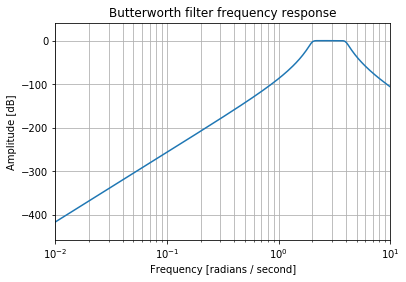

In [20]:
# Butterworth Filter
b, a = signal.butter(8, [2, 4], 'bandpass', analog=True)
w, h = signal.freqs(b, a)
plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()